Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Skin Cancer Data


### Importing all the important libraries

In [76]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob   
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [77]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [78]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [79]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2247
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [80]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [81]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset="training",
    follow_links=False
)

Found 6747 files belonging to 9 classes.
Using 5398 files for training.


In [82]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset="validation",
    follow_links=False
)

Found 6747 files belonging to 9 classes.
Using 1349 files for validation.


In [83]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


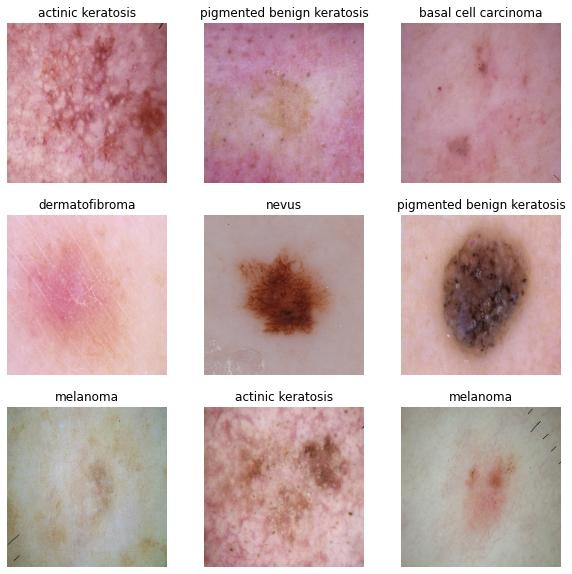

In [84]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [85]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
 Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [86]:
# Normalise the data with rescaling

#norm_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [87]:
### Lets build the 1st model as plane vanila
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [88]:
### Adding appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [89]:
# View the summary of all layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [90]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 38s 62ms/step - loss: 2.2315 - accuracy: 0.1983 - val_loss: 1.5925 - val_accuracy: 0.3462
Epoch 2/20
169/169 [==============================] - 3s 20ms/step - loss: 1.5108 - accuracy: 0.4134 - val_loss: 1.2980 - val_accuracy: 0.5256
Epoch 3/20
169/169 [==============================] - 3s 20ms/step - loss: 1.2218 - accuracy: 0.5478 - val_loss: 1.1217 - val_accuracy: 0.5930
Epoch 4/20
169/169 [==============================] - 3s 20ms/step - loss: 1.0561 - accuracy: 0.6183 - val_loss: 1.0258 - val_accuracy: 0.6353
Epoch 5/20
169/169 [==============================] - 3s 20ms/step - loss: 0.8755 - accuracy: 0.6844 - val_loss: 0.9129 - val_accuracy: 0.6812
Epoch 6/20
169/169 [==============================] - 3s 20ms/step - loss: 0.7344 - accuracy: 0.7360 - val_loss: 0.8780 - val_accuracy: 0.6790
Epoch 7/20
169/169 [==============================] - 3s 20ms/step - loss: 0.5960 - accuracy: 0.7931 - val_loss: 0.7861 - val_accuracy: 0.712

There's a huge margin diffrence between the train accuracy and validation accuracy.
Let's visualise the result

### Visualizing training results

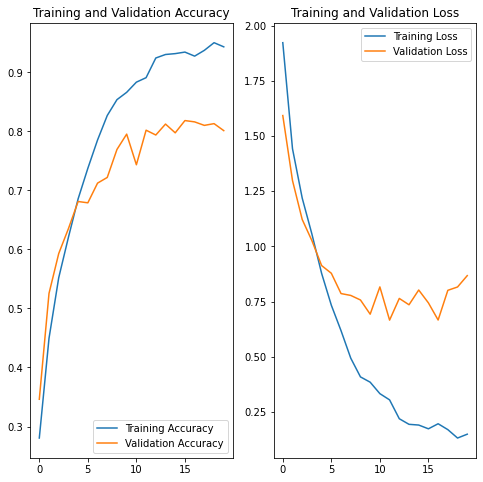

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

lets analyse the graph and accuracy metrics of last epoch
Train accuracy: 0.8940 val_accuracy: 0.5479

In the plot the training accuracy increasing over the time, however the validation accuracy becoma stagnant at ~55%, this clearly indicates the cas of overfitting.

In [92]:
# Data augumentation strategy with  tf.keras.layers.experimental.preprocessing. 

# strategy - 1 preprocessing layers for data augmentation

data_aug = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)


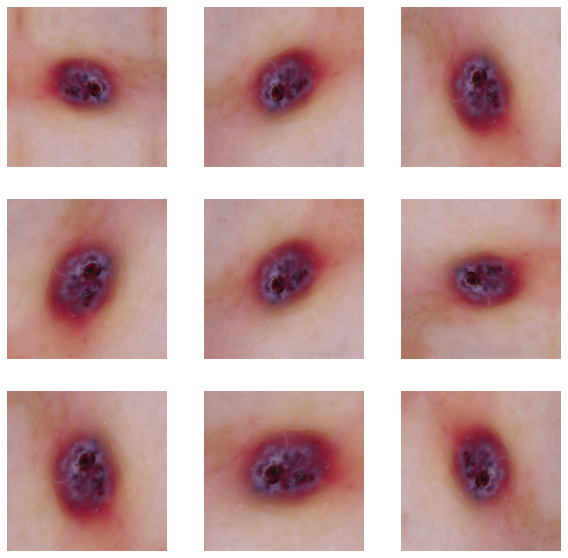

In [93]:
# Visualize how augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    aug_images = data_aug(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(aug_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [94]:
## using Dropout layer along with data augmentation as we have seen overfitting in earliar model.

model2 = Sequential([
  data_aug,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [95]:
## compile model2
### Adding appropirate optimiser and loss function
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [96]:
model2.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 45, 45, 64)       

### Training the model

In [97]:
## train your model for 20 epochs
epochs=20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 5s 23ms/step - loss: 1.9812 - accuracy: 0.2699 - val_loss: 1.6019 - val_accuracy: 0.3855
Epoch 2/20
169/169 [==============================] - 4s 22ms/step - loss: 1.5728 - accuracy: 0.3789 - val_loss: 1.3558 - val_accuracy: 0.4707
Epoch 3/20
169/169 [==============================] - 4s 22ms/step - loss: 1.4196 - accuracy: 0.4643 - val_loss: 1.3210 - val_accuracy: 0.4655
Epoch 4/20
169/169 [==============================] - 4s 22ms/step - loss: 1.3618 - accuracy: 0.4662 - val_loss: 1.2989 - val_accuracy: 0.4981
Epoch 5/20
169/169 [==============================] - 4s 22ms/step - loss: 1.3221 - accuracy: 0.4892 - val_loss: 1.3273 - val_accuracy: 0.4744
Epoch 6/20
169/169 [==============================] - 4s 22ms/step - loss: 1.2637 - accuracy: 0.5154 - val_loss: 1.1863 - val_accuracy: 0.5486
Epoch 7/20
169/169 [==============================] - 4s 22ms/step - loss: 1.2195 - accuracy: 0.5359 - val_loss: 1.1477 - val_accuracy: 0.5649

### Visualizing the results

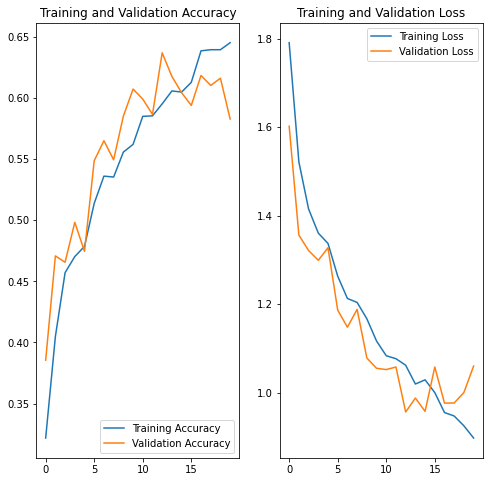

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We have got the accuracy of train and validation set after augmentation + dropout
1s 22ms/step - loss: 1.1326 - accuracy: 0.5917 - val_loss: 1.2854 - val_accuracy: 0.5657

 - We can see the case overfitting has been reduced.
 - Now we the overall accuracy has been dropped to 59% which can be   improved with some more tunning

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [99]:
# Let's look into the class imbalance
for cls in class_names:
    class_length = len(list(data_dir_train.glob(cls+'/*.jpg')))
    print(f'{cls} contains {class_length}')

actinic keratosis contains 114
basal cell carcinoma contains 376
dermatofibroma contains 95
melanoma contains 438
nevus contains 357
pigmented benign keratosis contains 462
seborrheic keratosis contains 77
squamous cell carcinoma contains 189
vascular lesion contains 139


#### - Which class has the least number of samples?
 - seborrheic keratosis contains: 77
 - dermatofibroma contains: 95

#### - Which classes dominate the data in terms proportionate number of samples?
 - pigmented benign keratosis contains 462
 - melanoma contains 438

####  Lets fix the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [100]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [101]:
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD2C00C7A10>:   0%|          | 1/500 [00:00<00:58,  8.50 Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD2C80FF810>: 100%|██████████| 500/500 [00:18<00:00, 26.94 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD314E18C10>: 100%|██████████| 500/500 [00:18<00:00, 27.22 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD2C00C7510>:   0%|          | 2/500 [00:00<00:28, 17.22 Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD312F64B10>: 100%|██████████| 500/500 [00:18<00:00, 26.53 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD2C3D53290>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1019x717 at 0x7FD2C3836BD0>: 100%|██████████| 500/500 [01:25<00:00,  5.85 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD2C0083BD0>:   0%|          | 1/500 [00:00<01:06,  7.45 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD314C9EED0>: 100%|██████████| 500/500 [00:18<00:00, 26.67 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FD2B4430350>: 100%|██████████| 500/500 [00:41<00:00, 12.13 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD2C0123DD0>:   0%|          | 1/500 [00:00<01:12,  6.91 Samples/s]

Initialised with 189 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD2C2EECDD0>: 100%|██████████| 500/500 [00:18<00:00, 27.23 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD2B4430210>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD300094D50>: 100%|██████████| 500/500 [00:18<00:00, 26.33 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [102]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [103]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_f96498e6-1d81-4ee7-bd5a-4b78d958a9ba.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_a4ae2ec9-cb0d-441d-9619-887020161fea.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027254.jpg_52972cef-d430-4294-85e2-af7d4edc998c.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_62702275-ed96-4140-8dab-e802b9141413.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_3a5b4f24-5256-4c01

In [104]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [105]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

####  Train the model on the data created using Augmentor

In [106]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [107]:
#data_dir_train= path_list
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11247 files belonging to 9 classes.
Using 8998 files for training.


#### **Todo:** Create a validation dataset

In [108]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11247 files belonging to 9 classes.
Using 2249 files for validation.


#### Create your model (make sure to include normalization)

In [109]:
model3 = Sequential([
  data_aug,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [110]:
## your code goes here

## compile model2
### Adding appropirate optimiser and loss function
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#### **Todo:**  Train your model

In [113]:
## train your model for 30 epochs
epochs=30
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
282/282 [==============================] - 59s 207ms/step - loss: 0.7402 - accuracy: 0.7168 - val_loss: 0.7524 - val_accuracy: 0.7190
Epoch 2/30
282/282 [==============================] - 59s 207ms/step - loss: 0.7168 - accuracy: 0.7247 - val_loss: 0.7995 - val_accuracy: 0.7114
Epoch 3/30
282/282 [==============================] - 59s 206ms/step - loss: 0.6997 - accuracy: 0.7392 - val_loss: 0.7778 - val_accuracy: 0.7092
Epoch 4/30
282/282 [==============================] - 59s 207ms/step - loss: 0.6939 - accuracy: 0.7414 - val_loss: 0.8736 - val_accuracy: 0.6745
Epoch 5/30
282/282 [==============================] - 59s 207ms/step - loss: 0.6607 - accuracy: 0.7472 - val_loss: 0.6946 - val_accuracy: 0.7546
Epoch 6/30
282/282 [==============================] - 59s 207ms/step - loss: 0.6436 - accuracy: 0.7598 - val_loss: 0.6905 - val_accuracy: 0.7603
Epoch 7/30
282/282 [==============================] - 59s 207ms/step - loss: 0.6380 - accuracy: 0.7588 - val_loss: 0.7097 - val_ac

#### **Todo:**  Visualize the model results

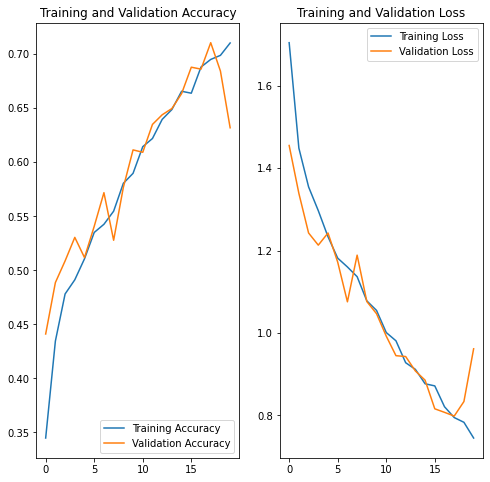

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**bold text**####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- With Augmentor we are able to add 4500 new data to the train_ds which has certainly reduced the class imbalance for large extent.
- Dropouts and augmentation has reduced the overfiting, which we have monitored on model2.
- The overall accuracy on train and validation se has imporved in model3

The final model i.e model3
- Train accuracy: 0.8289 
- val_loss: 0.5680 
- val_accuracy: 0.7888

With this metrics, we can observe the training and validation accuracy diff ~5%, which can be stated as an acceptable model.